In [1]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from tqdm import tqdm
from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 1. load data

In [2]:
# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split('/')[-1].split('.')[0]

    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# 提取锂电池容量
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

## 1.1 Extract raw data

In [3]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = r'dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data = loadMat(path)
    Battery[name] = getBatteryCapacity(data)              # 放电时的容量数据

Load Dataset B0005.mat ...


C:\Users\Dragon1573\AppData\Local\Temp\ipykernel_16860\2168350646.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


## or 1.1 load the extracted data

**如果上面的数据集读取失败，可以通过下面的方式加载已提取出来的数据**

In [4]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018'] # 4 个数据集的名字
Battery = np.load('dataset/NASA.npy', allow_pickle=True)
Battery = Battery.item()

## 1.2 plot figures for capacity degradation

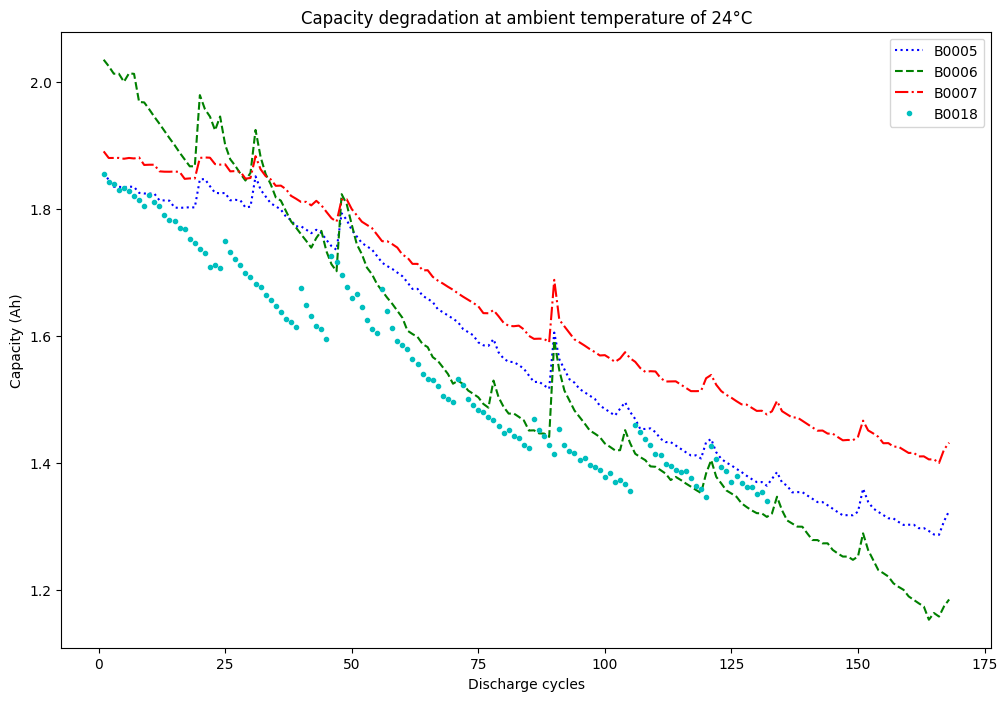

In [5]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()

# 2. data processing and model

## 2.1 data processing for model training

In [6]:
def build_instances(sequence, window_size):
    #sequence: list of capacity
    x, y = [],[]
    for i in range(len(sequence) - window_size):
        features = sequence[i:i+window_size]
        target = sequence[i+window_size]

        x.append(features)
        y.append(target)
        
    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    
    return train_data, test_data


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v[1], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
            
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
            
    score = abs(true_re - pred_re)/true_re
    if score > 1: score = 1
        
    return score


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) 
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

# 2.2 build net

In [7]:
class Net(nn.Module):
    def __init__(self, hidden_dim=8, num_layers=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
 
    def forward(self, x):           # x shape: (batch_size, feature_size, 1)
        out, _ = self.cell(x)       # out shape: (batch_size, feature_size, hidden_dim)
        out = out[:, -1, :]         # 取序列最后一个时间步的输出作为预测  
        out = self.linear(out)      # out shape: (batch_size, 1)
        return out

## 2.3 train for model

In [8]:
def train(lr, feature_size, hidden_dim=64, num_layers=2, weight_decay=0.0, mode='RNN', epochs=1000, seed=0, device='cpu', metric='rmse'):
    score_list, result_list = [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        test_x, test_y = build_instances(test_sequence, feature_size)
        # print('sample size: {}'.format(len(train_x)))
        
        model = Net(hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss().to(device)

        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = 1,1
        for epoch in range(epochs):
            X = np.reshape(train_x/Rated_Capacity,(-1, feature_size, 1))   # (batch_size, feature_size, 1)
            y = np.reshape(train_y/Rated_Capacity,(-1,1))          # shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()            
            loss.backward()                    
            optimizer.step()                   

            if (epoch + 1) % 100 == 0:
                x = np.reshape(test_x/Rated_Capacity,(-1, feature_size, 1))
                x = torch.from_numpy(x).to(device) 
                pred = model(x) 
                point_list = pred.data.cpu().numpy() * Rated_Capacity
                point_list = point_list.reshape(-1)
                
                y_.append(point_list)                                 
                loss_list.append(loss)
                rmse = evaluation(y_test=test_y, y_predict=y_[-1])
                re = relative_error(y_test=test_y, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
            
            if metric == 're':
                score = [re]
            else:
                score = [rmse]
                
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(train_data.copy()[:-1] + list(y_[-1]))
        
    return score_list, result_list

## 2.4 setting and training for overall performance

In [9]:
feature_size = 16
epochs = 500
lr = 0.001           # learning rate
hidden_dim = 128
num_layers = 1
weight_decay = 0.0
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0
metric = 'rmse'
device = "cuda:0" if torch.cuda.is_available() else "cpu"

SCORE = []
for seed in tqdm(range(4)):
    print('seed: ', seed)
    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, epochs=epochs, seed=seed, device=device, metric=metric)
    print(np.array(score_list))
    print(metric + ': for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
print(metric + ': mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

  0%|                                                                                                                                                               | 0/4 [00:00<?, ?it/s]

seed:  0


 25%|█████████████████████████████████████▊                                                                                                                 | 1/4 [00:06<00:18,  6.17s/it]

[[0.01910924]
 [0.03596512]
 [0.02061446]
 [0.0303524 ]]
rmse: for this seed: 0.0265
------------------------------------------------------------------
seed:  1


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 2/4 [00:11<00:11,  5.84s/it]

[[0.019316  ]
 [0.03794073]
 [0.02085117]
 [0.03042808]]
rmse: for this seed: 0.0271
------------------------------------------------------------------
seed:  2


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 3/4 [00:17<00:05,  5.67s/it]

[[0.01916568]
 [0.04075742]
 [0.01980465]
 [0.03136418]]
rmse: for this seed: 0.0278
------------------------------------------------------------------
seed:  3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.65s/it]

[[0.02020167]
 [0.03860005]
 [0.01983376]
 [0.03104038]]
rmse: for this seed: 0.0274
------------------------------------------------------------------
rmse: mean: 0.0272


## 2.5 prediction for figures

**select the seed of the best performance**

In [10]:
seed = 0

feature_size = 16
epochs = 500
lr = 0.001           # learning rate
hidden_dim = 128
num_layers = 1
weight_decay = 0.0
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0
metric = 'rmse'
device = 'cpu'

SCORE = []
print('seed: ', seed)
score_list, prediction_list = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                                    weight_decay=weight_decay, mode=mode, epochs=epochs, seed=seed, device=device, metric=metric)

print(np.array(score_list))
print(metric + ' for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))

seed:  0
[[0.01910904]
 [0.035973  ]
 [0.02061452]
 [0.03035242]]
rmse for this seed: 0.0265


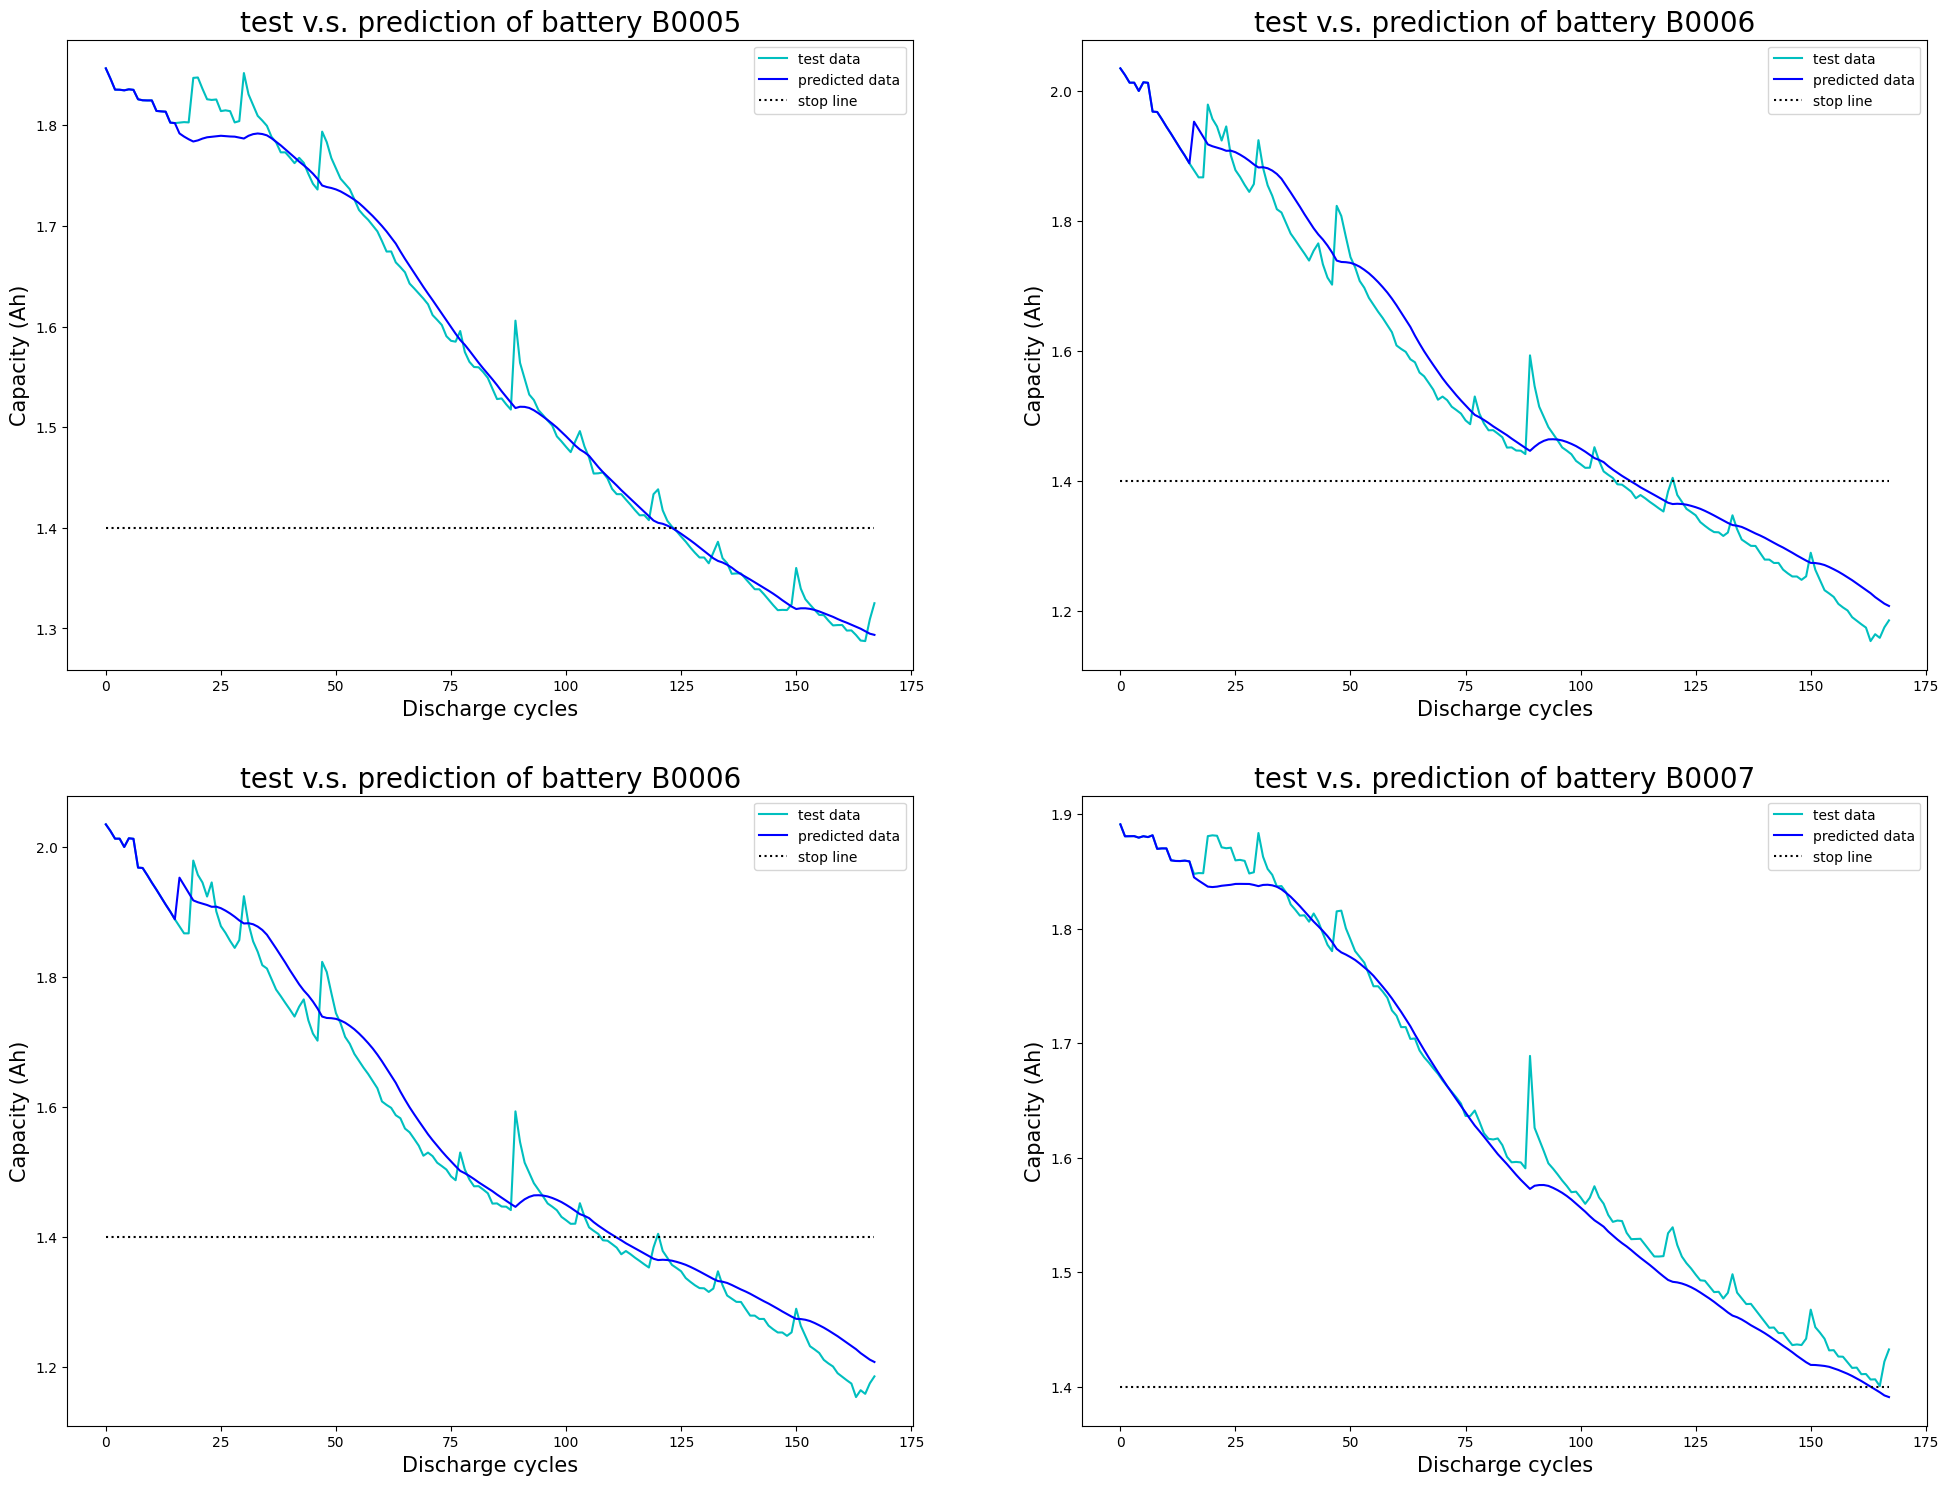

In [11]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name][1]
        predict_data = prediction_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, predict_data, 'b', label='predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()